In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import warnings
import time
warnings.filterwarnings('ignore')

In [2]:
# pip install scikit-learn==1.2.2

In [3]:
# download data
df = pd.read_csv('/Users/shuva/Downloads/UCI_Credit_Card.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [4]:
# X and y
X = df.drop(columns=['default.payment.next.month', 'ID'])
y = df.loc[:, 'default.payment.next.month']

In [5]:
Counter(y)

Counter({1: 6636, 0: 23364})

In [6]:
# Let's try classic Logit Model
# MinMaxScaler
X_for_logit = pd.DataFrame(MinMaxScaler().fit_transform(X))
X_for_logit.columns = X.columns

In [7]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_for_logit, y, test_size=0.2, random_state=0)

Logistic Regression

Confusion matrix 
 [[4613   90]
 [1006  291]]
Recall: 0.224
Precision: 0.764
Accuracy: 0.817 

AUC train: 0.721


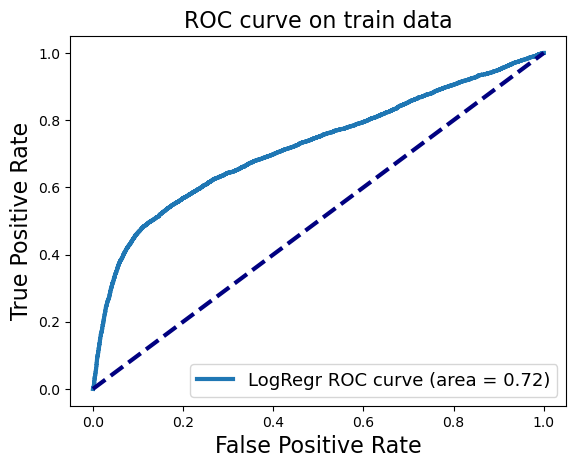

AUC test: 0.717


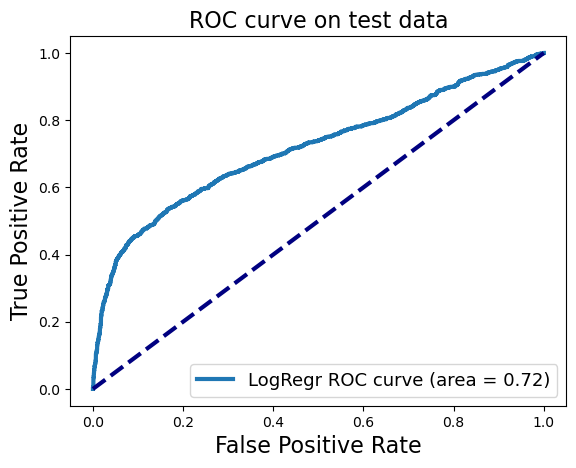

In [8]:
# Logit 
lg1 = LogisticRegression().fit(X_train, y_train)
p = lg1.predict(X_test)

print('Confusion matrix \n', confusion_matrix(y_test, p))
print('Recall: {:.3f}'.format(recall_score(y_test, p)))
print('Precision: {:.3f}'.format(precision_score(y_test, p)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, p)), '\n')

p_train = lg1.predict_proba(X_train)[:,1]
p_test = lg1.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_train, p_train.reshape(-1, 1))
print('AUC train: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve on train data', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, p_test.reshape(-1, 1))
print('AUC test: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve on test data', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

In [9]:
# Grid search LOgReg, let's try to optimize Recall

grid_params = {'C': [0.01, 0.1, 1.0, 5, 10, 100, 1000]}
lg2 = LogisticRegression().fit(X_train, y_train)

grid1 = GridSearchCV(lg2,param_grid=grid_params, scoring='recall').fit(X_train, y_train)

print('Grid best parameter (max. {0}): {1}'.format('recall', grid1.best_params_))
print('Grid best score ({0}): {1}'.format('recall', grid1.best_score_))

Grid best parameter (max. recall): {'C': 1000}
Grid best score (recall): 0.23543538009540557


In [10]:
lg2 = LogisticRegression(C=1000).fit(X_train, y_train)
lg2.coef_

array([[ -0.77551479,  -0.13215862,  -0.76232064,  -0.57615092,
          0.4414221 ,   5.53685807,   0.79057858,   0.9710585 ,
         -0.13390106,   0.51777932,   0.13165802,  -5.57670255,
          1.61292371,   0.24170028,   0.70167928,   0.80125735,
          1.33722547, -12.14961492,  -8.12020438,  -5.09153036,
         -4.3907974 ,  -0.71398158,  -1.08929261]])

In [11]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_test2 = X_test
y_test2 = y_test

Random Forest

Confusion matrix 
 [[4432  271]
 [ 799  498]]
Recall: 0.384
Precision: 0.648
Accuracy: 0.822 

AUC train: 1.000


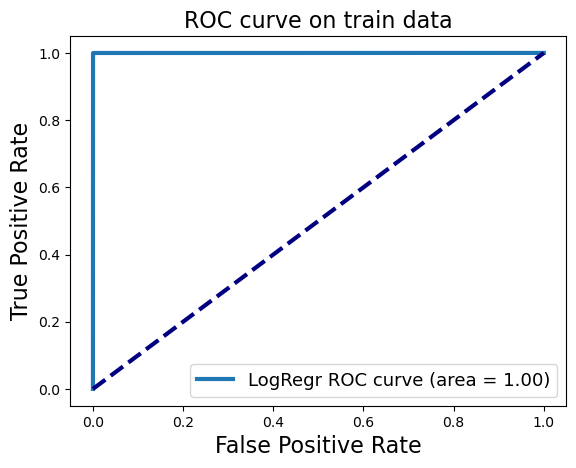

AUC test: 0.765


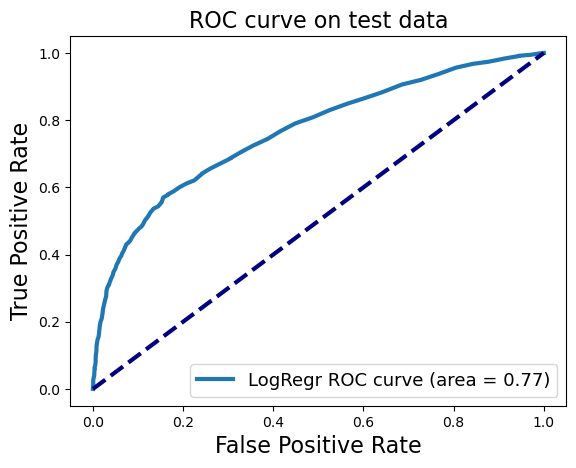

In [12]:
# Random Forest
rf1 = RandomForestClassifier(random_state=0).fit(X_train, y_train)
p = rf1.predict(X_test)

print('Confusion matrix \n', confusion_matrix(y_test, p))
print('Recall: {:.3f}'.format(recall_score(y_test, p)))
print('Precision: {:.3f}'.format(precision_score(y_test, p)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, p)), '\n')

p_train = rf1.predict_proba(X_train)[:,1]
p_test = rf1.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_train, p_train.reshape(-1, 1))
print('AUC train: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve on train data', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, p_test.reshape(-1, 1))
print('AUC test: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve on test data', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

In [18]:
#Grid search RandomForest, let's try to optimize Recall
start = time.time()
grid_params = {'max_depth': [2,3,4,5, 6, 7], 'min_samples_leaf': [1, 2, 3,4, 5,7]}   
rf2 = RandomForestClassifier(random_state=0).fit(X_train, y_train)

grid1 = GridSearchCV(rf2,param_grid=grid_params, scoring='roc_auc',n_jobs=10 ).fit(X_train, y_train)

print('Grid best parameter (max. {0}): {1}'.format('recall', grid1.best_params_))
print('Grid best score ({0}): {1}'.format('recall', grid1.best_score_))
print((time.time()-start)/60)

Grid best parameter (max. recall): {'max_depth': 7, 'min_samples_leaf': 7}
Grid best score (recall): 0.8360208869219357
4.701225010553996


XGBClassifier

Confusion matrix 
 [[4451  252]
 [ 820  477]]
Recall: 0.368
Precision: 0.654
Accuracy: 0.821 

AUC train: 0.938


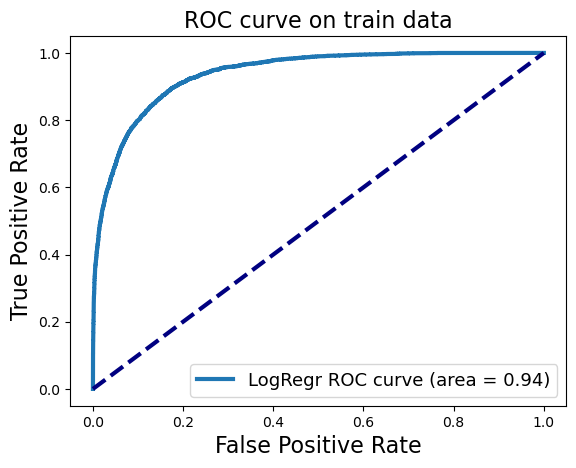

AUC test: 0.766


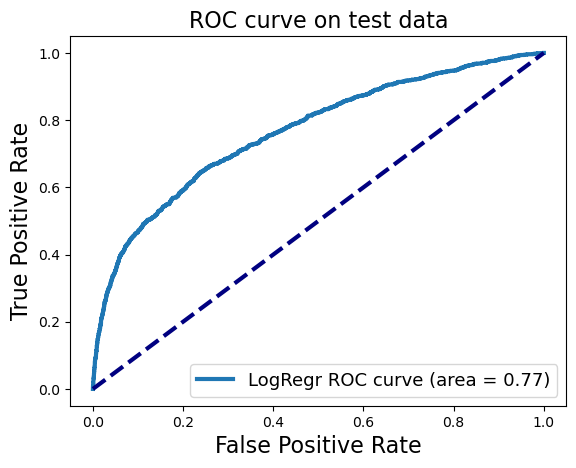

In [14]:
# XGB
grb1 = XGBClassifier(random_state=0).fit(X_train, y_train)
p = grb1.predict(X_test)

print('Confusion matrix \n', confusion_matrix(y_test, p))
print('Recall: {:.3f}'.format(recall_score(y_test, p)))
print('Precision: {:.3f}'.format(precision_score(y_test, p)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, p)), '\n')

p_train = grb1.predict_proba(X_train)[:,1]
p_test = grb1.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_train, p_train.reshape(-1, 1))
print('AUC train: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve on train data', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, p_test.reshape(-1, 1))
print('AUC test: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve on test data', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

## SMOTE

In [15]:
# SMOTE
X_train, y_train = SMOTE(random_state=0).fit_resample(X_train, y_train)
Counter(y_train)

Counter({0: 18661, 1: 18661})

Confusion matrix 
 [[4101  602]
 [ 691  606]]
Recall: 0.467
Precision: 0.502
Accuracy: 0.784 

AUC train: 1.000


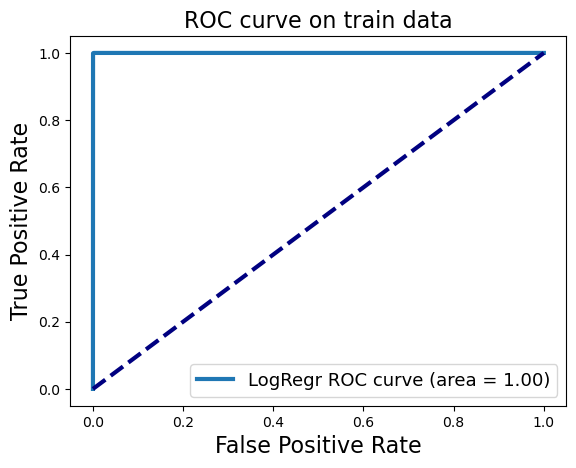

AUC test: 0.743


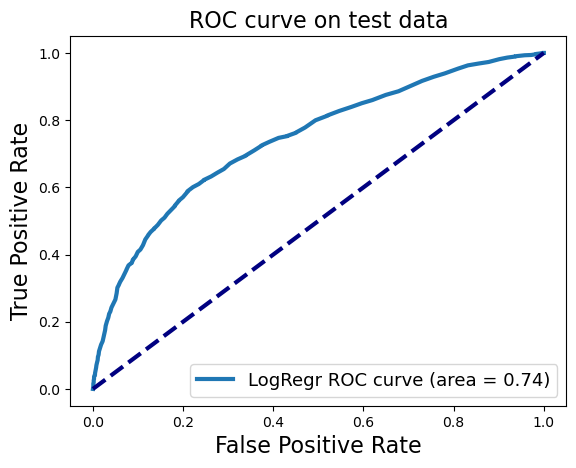

In [16]:
# Random Forest
rf2 = RandomForestClassifier(random_state=0).fit(X_train, y_train)
p = rf2.predict(X_test)

print('Confusion matrix \n', confusion_matrix(y_test, p))
print('Recall: {:.3f}'.format(recall_score(y_test, p)))
print('Precision: {:.3f}'.format(precision_score(y_test, p)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, p)), '\n')

p_train = rf2.predict_proba(X_train)[:,1]
p_test = rf2.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_train, p_train.reshape(-1, 1))
print('AUC train: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve on train data', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, p_test.reshape(-1, 1))
print('AUC test: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve on test data', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

[15:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

Confusion matrix 
 [[4067  636]
 [ 716  581]]
Recall: 0.448
Precision: 0.477
Accuracy: 0.775 

AUC train: 0.983


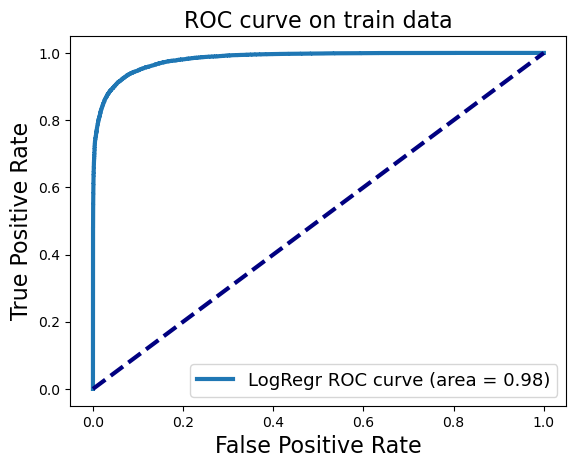

AUC test: 0.736


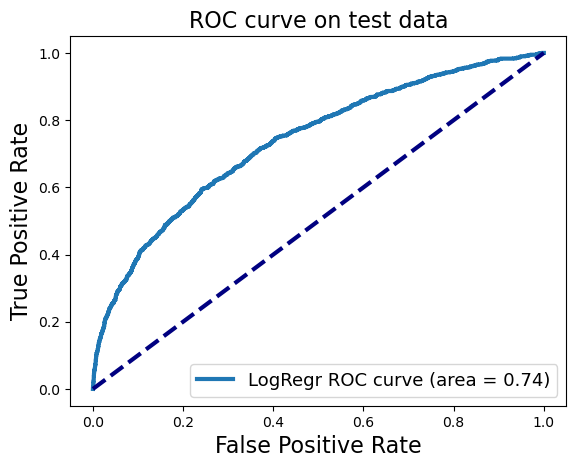

In [19]:
# XGB
grb2 = XGBClassifier(random_state=0, max_depth = 7, min_samples_leaf= 7).fit(X_train, y_train)
p = grb2.predict(X_test)

print('Confusion matrix \n', confusion_matrix(y_test, p))
print('Recall: {:.3f}'.format(recall_score(y_test, p)))
print('Precision: {:.3f}'.format(precision_score(y_test, p)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, p)), '\n')

p_train = grb2.predict_proba(X_train)[:,1]
p_test = grb2.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_train, p_train.reshape(-1, 1))
print('AUC train: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve on train data', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, p_test.reshape(-1, 1))
print('AUC test: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve on test data', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()